 # Hand Gesture Recognition for Sign Language Communication

##### Overview of the project: 

This project focuses on developing a hand gesture recognition system for sign language communication. The process begins with detecting key points on the face, pose, and hands using the Mediapipe library. These key points are then captured in real-time from a live video feed and saved as numpy arrays for each frame, organized into folders based on predefined actions (such as 'HI', 'Like', 'Thanks'). The data is preprocessed to create sequences of 30 frames per action, which are split into train, validation, and test sets. Three different models are trained on this preprocessed data: an LSTM model for sequence classification, a CNN model for sequence classification, and a Temporal Convolutional Network (TCN) model. These models are evaluated on the test set, with metrics such as accuracy and F1 score calculated. The trained models are then used for real-time inference, predicting actions from live video feed and displaying the recognized gestures along with confidence levels in real time. The project aims to provide a robust system for interpreting sign language gestures through Deep learning techniques

#  Import and Install Dependencies

In [10]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.4.1


In [59]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten

#  Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_landmarks(image, results):
    # face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        draw_styled_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
results.right_hand_landmarks

landmark {
  x: 0.11430880427360535
  y: 0.6338372230529785
  z: 4.0968620851344895e-07
}
landmark {
  x: 0.18160486221313477
  y: 0.5929884910583496
  z: -0.023090098053216934
}
landmark {
  x: 0.22421219944953918
  y: 0.5236032605171204
  z: -0.02650921791791916
}
landmark {
  x: 0.24205616116523743
  y: 0.45362046360969543
  z: -0.028433484956622124
}
landmark {
  x: 0.24821853637695312
  y: 0.3982938230037689
  z: -0.030309053137898445
}
landmark {
  x: 0.18806114792823792
  y: 0.4316723048686981
  z: -0.006320144981145859
}
landmark {
  x: 0.20855987071990967
  y: 0.350559800863266
  z: -0.0194768775254488
}
landmark {
  x: 0.217196524143219
  y: 0.29712697863578796
  z: -0.03259040415287018
}
landmark {
  x: 0.22190508246421814
  y: 0.25086167454719543
  z: -0.04226076230406761
}
landmark {
  x: 0.15120036900043488
  y: 0.4203414022922516
  z: -0.005781163927167654
}
landmark {
  x: 0.16257546842098236
  y: 0.3298395276069641
  z: -0.016701703891158104
}
landmark {
  x: 0.1688438

In [9]:
len(results.right_hand_landmarks.landmark)

21

In [10]:
draw_landmarks(frame, results)

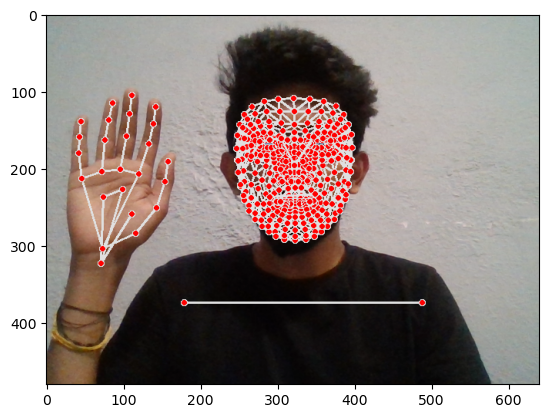

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [13]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [14]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
result_test = extract_keypoints(results)

In [17]:
result_test

array([ 0.50408226,  0.40978563, -1.11079979, ...,  0.07053632,
        0.29015666, -0.04400296])

In [18]:
np.save('0', result_test)

In [19]:
np.load('0.npy')

array([ 0.50408226,  0.40978563, -1.11079979, ...,  0.07053632,
        0.29015666, -0.04400296])

# Setup Folders for Collection

In [20]:
# Folder path to create and save the video frames
DATA_PATH = os.path.join('MP_Data') 

# Actions that detect
actions = np.array(['HI', 'Like','Thanks'])

# Forty videos of data
no_sequences = 40

# Videos with 30 frames in length
sequence_length = 30

In [21]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [22]:
#Capture the real time action detection as input video frames
cap = cv2.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):

                # Read the input
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                draw_styled_landmarks(image, results)
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                #keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [23]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [24]:
label_map = {label:num for num, label in enumerate(actions)}

In [25]:
label_map

{'HI': 0, 'Like': 1, 'Thanks': 2}

In [26]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [27]:
X = np.array(sequences)

In [28]:
X.shape

(120, 30, 1662)

In [29]:
y = to_categorical(labels).astype(int)

In [30]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [32]:
y_test.shape

(48, 3)

# Build and Train LSTM Neural Network

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [45]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

C:\Users\PAVAN TEJA\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
res = [.7, 0.2, 0.1]

In [37]:
actions[np.argmax(res)]

'HI'

In [46]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - categorical_accuracy: 0.2326 - loss: 1.3749
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.3928 - loss: 2.7732
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.3060 - loss: 1.7321
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_accuracy: 0.2739 - loss: 2.6112
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.3038 - loss: 2.2016
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_accuracy: 0.3207 - loss: 2.0170
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_accuracy: 0.3277 - loss: 22.8867
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_accuracy: 0.3928 - loss: 37.8414
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.6688 - loss: 6.4547
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.2609 - loss: 4.3258
Epoch 11/2000
3/3 ━━━━━━━━

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

In [41]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step


In [42]:
actions[np.argmax(res[1])]
# actions[np.argmax(y_test[2])]

'Thanks'

In [43]:
model.save('action.h5')

In [44]:
del model

In [47]:
model.load_weights('action.h5')


# Evaluation using Confusion Matrix and Accuracy

In [48]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,f1_score

In [49]:
yhat = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


In [50]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [51]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[31,  0],
        [ 2, 15]],

       [[35,  0],
        [ 2, 11]],

       [[26,  4],
        [ 0, 18]]], dtype=int64)

In [52]:
accuracy_score(ytrue, yhat)

0.9166666666666666

In [53]:
f1 = f1_score(ytrue, yhat, average='macro')

print("F1 Score:", f1)

F1 Score: 0.9180555555555555


# Test in Real Time

In [91]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [294]:
# New variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        # Give detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [235]:
cap.release()
cv2.destroyAllWindows()

In [96]:
res[np.argmax(res)] > threshold

False

In [97]:
(no_sequences,30,1662)

(40, 30, 1662)

In [98]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[0.8687355 , 0.11503797, 0.01622649]], dtype=float32)

# Build and Train CNN

In [79]:
# File path
log_dir = os.path.join('CNN_Logs')
tb_callback = TensorBoard(log_dir=log_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model
model = Sequential()
# Convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 1662)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output from Convolutional layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer
num_classes = y.shape[1]
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, callbacks=[tb_callback])

C:\Users\PAVAN TEJA\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.3307 - loss: 1.1120 - val_accuracy: 0.3333 - val_loss: 1.1111
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3542 - loss: 1.0896 - val_accuracy: 0.2917 - val_loss: 1.0736
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2895 - loss: 1.0696 - val_accuracy: 0.2917 - val_loss: 1.0943
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3446 - loss: 1.0532 - val_accuracy: 0.5000 - val_loss: 1.0355
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4466 - loss: 1.0021 - val_accuracy: 0.3750 - val_loss: 0.9630
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5573 - loss: 0.9421 - val_accuracy: 0.7708 - val_loss: 0.9496
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6484 - loss: 0.9243 - val_accuracy: 0.6458 - val_loss: 0.9003
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5972 - loss: 0.9010 - val_accuracy: 0.8750 - val_loss: 0.85

In [80]:
model.save('actionCNN.h5')

In [81]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Get the predicted labels
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded true labels to categorical labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Test Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print("F1 Score:", f1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9271 - loss: 0.3204 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Test Accuracy: 0.9375
F1 Score: 0.9388376856118791


In [82]:
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.9375


In [83]:
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print("F1 Score:", f1)


F1 Score: 0.9388376856118791


In [84]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 28, 32)              │         159,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 12, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 4, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 627,371 (2.39 MB)

 Trainable params: 209,123 (816.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 418,248 (1.60 MB)

In [69]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [70]:
actions[np.argmax(y_test[3])]

'Like'

# Build and Train TCN

### TCN Model

In [72]:
DATA_PATH = 'MP_Data'
ACTIONS = np.array(['HI', 'Like', 'Thanks'])
SEQUENCE_LENGTH = 30

# Define TCN model
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels=[64]*8, kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels[0], kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        for i in range(1, len(num_channels)):
            self.tcn.add_module(f'conv{i}', nn.Conv1d(num_channels[i-1], num_channels[i], kernel_size=kernel_size, padding=(kernel_size - 1) // 2))
            self.tcn.add_module(f'relu{i}', nn.ReLU())
            self.tcn.add_module(f'dropout{i}', nn.Dropout(dropout))
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y = self.tcn(x.permute(0, 2, 1))
        y = y[:, :, -1]
        y = self.linear(y)
        return y

### Preprocessing and Normalization

In [73]:
def normalize_keypoints(keypoints):
    normalized_keypoints = keypoints
    return normalized_keypoints

# padding or truncation
def pad_or_truncate_sequence(sequence, sequence_length):
    if len(sequence) < sequence_length:
        sequence = np.pad(sequence, ((0, sequence_length - len(sequence)), (0, 0)), mode='constant')
    elif len(sequence) > sequence_length:
        sequence = sequence[:sequence_length]
    return sequence

class ActionDataset(Dataset):
    def __init__(self, data_path, actions, sequence_length):
        self.data_path = data_path
        self.actions = actions
        self.sequence_length = sequence_length
        self.data = self.load_data()

    def load_data(self):
        data = []
        for action_idx, action in enumerate(self.actions):  # Add index to actions
            for sequence in os.listdir(os.path.join(self.data_path, action)):
                if sequence != ".DS_Store":
                    sequence_path = os.path.join(self.data_path, action, sequence)
                    frames = []
                    for frame in os.listdir(sequence_path):
                        frame_path = os.path.join(sequence_path, frame)
                        keypoints = np.load(frame_path)
                        normalized_keypoints = normalize_keypoints(keypoints)
                        padded_sequence = pad_or_truncate_sequence(normalized_keypoints, self.sequence_length)
                        frames.append(padded_sequence)
                    data.append({'action': action_idx, 'sequence': torch.tensor(frames, dtype=torch.float32)})
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        action, sequence = sample['action'], sample['sequence']
        return {'action': action, 'sequence': sequence}

### Train, Validation, and Test

In [85]:
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42)
    return train_data, val_data, test_data

dataset = ActionDataset(DATA_PATH, ACTIONS, SEQUENCE_LENGTH)
train_data, val_data, test_data = split_data(dataset.data)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# model parameters
input_size = 30
output_size = len(ACTIONS)
num_channels = [64] * 8
kernel_size = 3
dropout = 0.2
num_epochs = 2000
learning_rate = 1e-3

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            sequences, labels = inputs['sequence'], inputs['action']
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * sequences.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.no_grad():  # Disable gradient computation during validation
            for inputs in val_loader:
                sequences, labels = inputs['sequence'], inputs['action']
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * sequences.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    test_loss = 0.0
    test_preds = []
    test_labels = []
    model.eval()
    with torch.no_grad():  # Disable gradient computation during test
        for inputs in test_loader:
            sequences, labels = inputs['sequence'], inputs['action']
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * sequences.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}')


# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/2000, Train Loss: 1.1001, Val Loss: 1.0969, Val Accuracy: 0.3846
Epoch 2/2000, Train Loss: 1.0979, Val Loss: 1.0971, Val Accuracy: 0.3846
Epoch 3/2000, Train Loss: 1.0986, Val Loss: 1.0965, Val Accuracy: 0.3846
Epoch 4/2000, Train Loss: 1.1006, Val Loss: 1.0963, Val Accuracy: 0.3846
Epoch 5/2000, Train Loss: 1.0995, Val Loss: 1.0963, Val Accuracy: 0.3846
Epoch 6/2000, Train Loss: 1.0972, Val Loss: 1.0963, Val Accuracy: 0.3846
Epoch 7/2000, Train Loss: 1.0981, Val Loss: 1.0963, Val Accuracy: 0.3846
Epoch 8/2000, Train Loss: 1.0985, Val Loss: 1.0965, Val Accuracy: 0.3846
Epoch 9/2000, Train Loss: 1.0987, Val Loss: 1.0965, Val Accuracy: 0.3846
Epoch 10/2000, Train Loss: 1.0996, Val Loss: 1.0964, Val Accuracy: 0.3846
Epoch 11/2000, Train Loss: 1.0992, Val Loss: 1.0965, Val Accuracy: 0.3846
Epoch 12/2000, Train Loss: 1.0985, Val Loss: 1.0966, Val Accuracy: 0.3846
Epoch 13/2000, Train Loss: 1.0981, Val Loss: 1.0966, Val Accuracy: 0.3846
Epoch 14/2000, Train Loss: 1.0978, Val Loss: 1.

In [86]:
# Save the trained model
torch.save(model.state_dict(), 'actionTCN.pth')

In [87]:
test_preds = []
test_labels = []
model.eval()
with torch.no_grad():  # Disable gradient computation during test
    for inputs in test_loader:
        sequences, labels = inputs['sequence'], inputs['action']
        outputs = model(sequences)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test F1 Score: {test_f1:.4f}')


Test Accuracy: 0.4722, Test F1 Score: 0.4773
